In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

import torch.nn as nn
import spacegm

In [2]:
adata1 = sc.read('Chris_HTMA_480_15_reg001_anndata.h5ad')
mapping_df1 = pd.read_csv('Chris_HTMA_480_15_reg001_h5path_channel_order.txt', sep='\t', header=None, names=['index', 'marker'])
tma = 'Chris_HTMA_480_15'
adata1.obs['x'] = adata1.obs['x'].round(4)
adata1.obs['y'] = adata1.obs['y'].round(4)
df = pd.read_csv("metadata_10_18.csv")
df = df[df['orig.ident'] == tma]
df['x'] = df['x'].round(4)
df['y'] = df['y'].round(4)
mask = adata1.obs[['x', 'y']].apply(tuple, axis=1).isin(df[['x', 'y']].apply(tuple, axis=1))
adata_subset = adata1[mask]
adata_subset.obs = adata_subset.obs.merge(df, on=['x', 'y'], how='left')
adata1 = adata_subset.copy()


adata2 = sc.read('Chris_HTMA_480_16_20231115_Chris_HTMA_480_16_Transfer_anndata.h5ad')
mapping_df2 = pd.read_csv('Chris_HTMA_480_16_20231115_Chris_HTMA_480_16_Transfer_h5path_channel_order.txt', sep='\t', header=None, names=['index', 'marker'])
tma = 'Chris_HTMA_480_16'
adata2.obs['x'] = adata2.obs['x'].round(4)
adata2.obs['y'] = adata2.obs['y'].round(4)
df = pd.read_csv("metadata_10_18.csv")
df = df[df['orig.ident'] == tma]
df['x'] = df['x'].round(4)
df['y'] = df['y'].round(4)
mask = adata2.obs[['x', 'y']].apply(tuple, axis=1).isin(df[['x', 'y']].apply(tuple, axis=1))
adata_subset = adata2[mask]
adata_subset.obs = adata_subset.obs.merge(df, on=['x', 'y'], how='left')
adata2 = adata_subset.copy()

adata2.obs['x'] += adata2.obs['x'].max()+1000

adata_c = sc.concat([adata1, adata2])
adata_c

AnnData object with n_obs × n_vars = 973056 × 37
    obs: 'y', 'x', 'label', 'filled_area', 'euler_number', 'Unnamed: 0', 'orig.ident', 'nCount_MFI', 'nFeature_MFI', 'nCount_zscores', 'nFeature_zscores', 'sample_name', 'sample_type', 'leiden', 'leiden_refined', 'cell_population', 'samplename_andtype', 'exclude', 'simplified_1', 'simplified_2', 'simplified_3', 'simplified_4', 'simplified_5', 'simplified_6', 'simplified_7', 'survival', 'neighborhoods', 'neighborhood_names'
    obsm: 'spatial'
    layers: 'max_intensity', 'min_intensity'

In [3]:
# adata_x = sc.read("output-XETG00279__0038263__Region_1__20241018__191550_seg.h5ad")

In [3]:
adata_x = sc.read("updated_adata_x.h5ad")

In [5]:
adata_x

AnnData object with n_obs × n_vars = 538549 × 541
    obs: 'x', 'y', 'centroid_z', 'fov', 'cluster', 'volume', 'population', 'cell_type', 'cell_type_predicted', 'sample', 'sample_type'
    var: 'total_count', 'expected_assigned_count', 'dispersion_0', 'dispersion_1', 'dispersion_2', 'dispersion_3', 'dispersion_4', 'dispersion_5', 'dispersion_6', 'dispersion_7', 'dispersion_8', 'dispersion_9', 'λ_0', 'λ_1', 'λ_2', 'λ_3', 'λ_4', 'λ_5', 'λ_6', 'λ_7', 'λ_8', 'λ_9', 'λ_bg_0', 'λ_bg_1', 'λ_bg_2', 'λ_bg_3'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca', 'spatial'
    obsp: 'connectivities', 'distances'

In [7]:
adata_c = adata_c[adata_c.obs['neighborhood_names'] != 'none']

In [8]:
adata_c

View of AnnData object with n_obs × n_vars = 698373 × 37
    obs: 'y', 'x', 'label', 'filled_area', 'euler_number', 'Unnamed: 0', 'orig.ident', 'nCount_MFI', 'nFeature_MFI', 'nCount_zscores', 'nFeature_zscores', 'sample_name', 'sample_type', 'leiden', 'leiden_refined', 'cell_population', 'samplename_andtype', 'exclude', 'simplified_1', 'simplified_2', 'simplified_3', 'simplified_4', 'simplified_5', 'simplified_6', 'simplified_7', 'survival', 'neighborhoods', 'neighborhood_names'
    obsm: 'spatial'
    layers: 'max_intensity', 'min_intensity'

In [23]:
adata_x.obs.rename(columns={'sample': 'sample_name'}, inplace=True)
common_sample_names = set(adata_x.obs['sample_name']).intersection(adata_c.obs['sample_name'])
adata_x = adata_x[adata_x.obs['sample_name'].isin(common_sample_names)]
adata_c = adata_c[adata_c.obs['sample_name'].isin(common_sample_names)]

In [26]:
adata_x.obs['sample_name'].unique()

['S16-2647 B2', 'BA12-166 A2', 'H19-38010', 'S14-81178 7A', 'S16-25171 A1', ..., 'kj92914', 'S20-6172 A1', 'H18-036020', 'S19-46559', 'SP14-2895 A1']
Length: 29
Categories (29, object): ['1621120 B', 'A54624', 'BA12-166 A2', 'BS13-25499 A4', ..., 'SP14-2895 A1', 'SUH15-11470 B1', 'kj92914', 's18-6841 B1']

In [28]:
len(adata_c.obs['sample_name'].unique())

29

In [30]:
metadata = pd.read_csv("metadata_10_18.csv")
list(metadata.columns)

['Unnamed: 0',
 'orig.ident',
 'nCount_MFI',
 'nFeature_MFI',
 'x',
 'y',
 'nCount_zscores',
 'nFeature_zscores',
 'sample_name',
 'sample_type',
 'leiden',
 'leiden_refined',
 'cell_population',
 'samplename_andtype',
 'exclude',
 'simplified_1',
 'simplified_2',
 'simplified_3',
 'simplified_4',
 'simplified_5',
 'simplified_6',
 'simplified_7',
 'survival',
 'neighborhoods',
 'neighborhood_names']

In [ ]:
metadata[['sample_name', 'sample_type', 'samplename_andtype', 'survival', 'neighborhoods', 'neighborhood_names']]

In [34]:
master_df = pd.read_csv("master_annotated.csv")
adata_x.obs = adata_x.obs.merge(master_df, on='sample_name', how='left')
adata_c.obs = adata_c.obs.merge(master_df, on='sample_name', how='left')

In [426]:
adata_x = adata_x[~adata_x.obs['ex_group'].isna()]
adata_c = adata_c[~adata_c.obs['ex_group'].isna()]

In [427]:
if 'sample_name' in adata_x.obs.columns and 'sample_type' in adata_x.obs.columns:
    adata_x.obs['sample_name_type'] = adata_x.obs['sample_name'].astype(str) + "_" + adata_x.obs['sample_type'].astype(str)

if 'sample_name' in adata_c.obs.columns and 'sample_type' in adata_c.obs.columns:
    adata_c.obs['sample_name_type'] = adata_c.obs['sample_name'].astype(str) + "_" + adata_c.obs['sample_type'].astype(str)

In [428]:
if 'sample_name' in adata_c.obs.columns and 'sample_type' in adata_c.obs.columns:
    adata_c.obs['sample_name_type'] = adata_c.obs['sample_name'].astype(str) + "_" + adata_c.obs['sample_type'].astype(str)

if 'sample_name' in adata_c.obs.columns and 'sample_type' in adata_c.obs.columns:
    adata_c.obs['sample_name_type'] = adata_c.obs['sample_name'].astype(str) + "_" + adata_c.obs['sample_type'].astype(str)

In [429]:
common_sample_names_types = set(adata_x.obs['sample_name_type']).intersection(adata_c.obs['sample_name_type'])
adata_x = adata_x[adata_x.obs['sample_name_type'].isin(common_sample_names_types)]
adata_c = adata_c[adata_c.obs['sample_name_type'].isin(common_sample_names_types)]

In [494]:
for region_id in adata_x.obs['sample_name_type'].unique():
    print("Region ID: ", region_id)
    adata_x_subset = adata_x[adata_x.obs['sample_name_type'] == region_id]
    
    coordinates = pd.DataFrame(adata_x_subset.obsm['spatial'], columns=['X', 'Y'])
    coordinates['CELL_ID'] = coordinates.index 
    coordinates.to_csv(f'input_xenium/{region_id}.cell_coords_file.csv', index=False)
    
    cell_types = pd.DataFrame()
    cell_types['CELL_TYPE'] = adata_x_subset.obs[['cell_type']] 
    cell_types.reset_index(drop=True, inplace=True)
    cell_types['CELL_ID'] = cell_types.index 
    cell_types.to_csv(f'input_xenium/{region_id}.cell_types_file.csv', index=False)
    
    biomarker_df = pd.DataFrame(adata_x_subset.X.toarray() if hasattr(adata_x_subset.X, "toarray") else adata_x_subset.X, 
                                columns=adata_x_subset.var_names)
    biomarker_df.reset_index(drop=True, inplace=True)
    biomarker_df['CELL_ID'] = biomarker_df.index 
    biomarker_df['REGION_ID'] = region_id
    biomarker_df.to_csv(f'input_xenium/{region_id}.cell_biomarker_expression_file.csv', index=False)

    cell_features = pd.DataFrame(adata_x_subset.obs[['volume', 'population']])
    cell_features['CELL_ID'] = cell_features.index
    cell_features.to_csv(f"input_xenium/{region_id}.cell_features.csv", index = False)
    
metadata = pd.read_csv("master_annotated.csv")
metadata['REGION_ID'] = metadata['sample_name']
for r in region_ids[:12]:
    metadata.loc[metadata['REGION_ID'] == r.split("_")[0], 'REGION_ID'] = r
metadata['OS_high_low'] = (metadata['OS_days'] > 228).astype(int)
metadata.to_csv('input_xenium/metadata.csv', index=False)

Region ID:  S16-2647 B2_margin
Region ID:  BA12-166 A2_tumor
Region ID:  H19-38010_tumor
Region ID:  S16-25171 A1_tumor
Region ID:  S15-105098 B1_tumor
Region ID:  SUH15-11470 B1_margin
Region ID:  1621120 B_tumor
Region ID:  S19-27363 2B_margin
Region ID:  S21-6166 B5_margin
Region ID:  s18-6841 B1_margin
Region ID:  S20-8605 S12_margin
Region ID:  S21-21003 D5_tumor
Region ID:  LHS17-11125 A4_margin
Region ID:  S16-25171 A1_margin
Region ID:  JS12-2909 B1_tumor
Region ID:  LHS17-11125 A4_tumor
Region ID:  A54624_tumor
Region ID:  S18-21918 A2_tumor
Region ID:  H19-38010_margin
Region ID:  S12-9748 B2_tumor
Region ID:  HS16-10538 A3_margin
Region ID:  1621120 B_margin
Region ID:  HS16-10538 A3_tumor
Region ID:  MS19-7089 2A_tumor
Region ID:  A54624_margin
Region ID:  S18-4159 2A_tumor
Region ID:  S21-6166 B5_tumor
Region ID:  S20-8605 S12_tumor
Region ID:  S13-59471 3F_margin
Region ID:  S18-21918 A2_margin
Region ID:  MS19-7089 2A_margin
Region ID:  kj92914_tumor
Region ID:  S12-9748

In [495]:
for region_id in adata_c.obs['sample_name_type'].unique():
    print("Region ID: ", region_id)
    adata_c_subset = adata_c[adata_c.obs['sample_name_type'] == region_id]
    
    coordinates = pd.DataFrame(adata_c_subset.obsm['spatial'], columns=['x', 'y'])
    coordinates['CELL_ID'] = coordinates.index  
    coordinates.to_csv(f'input_codex/{region_id}.cell_coords_file.csv', index=False)
    
    cell_types = pd.DataFrame()
    cell_types['CELL_TYPE'] = adata_c_subset.obs[['simplified_2']] 
    cell_types.reset_index(drop=True, inplace=True)
    cell_types['CELL_ID'] = cell_types.index  
    cell_types.to_csv(f'input_codex/{region_id}.cell_types_file.csv', index=False)
    
    biomarker_df = pd.DataFrame(adata_c_subset.X.toarray() if hasattr(adata_c_subset.X, "toarray") else adata_c_subset.X, 
                                columns=adata_c_subset.var_names)
    biomarker_df.reset_index(drop=True, inplace=True)
    biomarker_df['CELL_ID'] = biomarker_df.index 
    biomarker_df['REGION_ID'] = region_id
    biomarker_df.to_csv(f'input_codex/{region_id}.cell_biomarker_expression_file.csv', index=False)

    cell_features = pd.DataFrame(adata_c_subset.obs['filled_area'])
    cell_features['CELL_ID'] = cell_features.index
    cell_features.to_csv(f"input_codex/{region_id}.cell_features.csv", index = False)
    
metadata = pd.read_csv("master_annotated.csv")
metadata['REGION_ID'] = metadata['sample_name']
for r in region_ids[:12]:
    metadata.loc[metadata['REGION_ID'] == r.split("_")[0], 'REGION_ID'] = r
metadata['OS_high_low'] = (metadata['OS_days'] > 228).astype(int)
metadata.to_csv('input_codex/metadata.csv', index=False)

Region ID:  SUH15-11470 B1_margin
Region ID:  MS19-7089 2A_tumor
Region ID:  S19-27363 2B_margin
Region ID:  S16-25171 A1_tumor
Region ID:  H18-036020_tumor
Region ID:  S16-2647 B2_tumor
Region ID:  A54624_tumor
Region ID:  H18-036020_margin
Region ID:  S16-2647 B2_margin
Region ID:  MS19-7089 2A_margin
Region ID:  S21-6166 B5_tumor
Region ID:  S16-25171 A1_margin
Region ID:  S21-21003 D5_tumor
Region ID:  A54624_margin
Region ID:  kj92914_tumor
Region ID:  BA12-166 A2_tumor
Region ID:  S18-21918 A2_tumor
Region ID:  S15-105098 B1_tumor
Region ID:  S21-6166 B5_margin
Region ID:  H19-38010_tumor
Region ID:  kj92914_margin
Region ID:  S18-4159 2A_tumor
Region ID:  S18-21918 A2_margin
Region ID:  S15-105098 B1_margin
Region ID:  LHS17-11125 A4_tumor
Region ID:  S21-21003 D5_margin
Region ID:  BA12-166 A2_margin
Region ID:  S18-4159 2A_margin
Region ID:  LHS17-11125 A4_margin
Region ID:  H19-38010_margin
Region ID:  S13-59471 3F_tumor
Region ID:  s18-6841 B1_margin
Region ID:  S12-9748 B2_

In [417]:
# adata_c = sc.read("adata_c_final.h5ad")
# adata_x = sc.read("adata_x_final.h5ad")

In [418]:
sc.pp.normalize_total(adata_x,target_sum=1e4)
sc.pp.normalize_total(adata_c,target_sum=1e4)
sc.pp.log1p(adata_x)
sc.pp.log1p(adata_c)

In [478]:
region_ids[:12]

['S16-2647 B2_margin',
 'BA12-166 A2_tumor',
 'H19-38010_tumor',
 'S16-25171 A1_tumor',
 'S15-105098 B1_tumor',
 'SUH15-11470 B1_margin',
 '1621120 B_tumor',
 'S19-27363 2B_margin',
 'S21-6166 B5_margin',
 's18-6841 B1_margin',
 'S20-8605 S12_margin',
 'S21-21003 D5_tumor']

In [438]:
# adata_x.write("adata_x_final_norm.h5ad")
# adata_c.write("adata_c_final_norm.h5ad")

In [497]:
raw_data_root = "input_xenium/"

dataset_root = "output_xenium/"
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

region_ids = list(adata_x.obs['sample_name_type'].astype(str).unique())

In [498]:
for region_id in region_ids[:12]:
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s.cell_coords_file.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s.cell_types_file.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s.cell_biomarker_expression_file.csv" % region_id)
    cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)
plt.close()
print("Finished!")

Processing S16-2647 B2_margin
Processing BA12-166 A2_tumor
Processing H19-38010_tumor
Processing S16-25171 A1_tumor
Processing S15-105098 B1_tumor
Processing SUH15-11470 B1_margin
Processing 1621120 B_tumor
Processing S19-27363 2B_margin
Processing S21-6166 B5_margin
Processing s18-6841 B1_margin
Processing S20-8605 S12_margin
Processing S21-21003 D5_tumor
Finished!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [499]:
raw_data_root = "input_codex/"

dataset_root = "output_codex/"
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

for region_id in region_ids[:12]:
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s.cell_coords_file.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s.cell_types_file.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s.cell_biomarker_expression_file.csv" % region_id)
    cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)

plt.close()
print("Finished!")

Processing S16-2647 B2_margin
Processing BA12-166 A2_tumor
Processing H19-38010_tumor
Processing S16-25171 A1_tumor
Processing S15-105098 B1_tumor
Processing SUH15-11470 B1_margin
Processing 1621120 B_tumor
Processing S19-27363 2B_margin
Processing S21-6166 B5_margin
Processing s18-6841 B1_margin
Processing S20-8605 S12_margin
Processing S21-21003 D5_tumor
Finished!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [500]:
import numpy as np
import networkx as nx
import ot


In [501]:
def create_feature_matrix(graph, all_markers):
    feature_matrix = []
    for node in graph.nodes:
        biomarker_expression = graph.nodes[node]['biomarker_expression']
        feature_vector = [biomarker_expression.get(marker, 0.0) for marker in all_markers]
        feature_matrix.append(feature_vector)
    return np.array(feature_matrix)


In [502]:
def compute_cost_matrix_incremental(graph_codex, graph_xenium, lambda_expression=0.9, lambda_spatial=0.1):

    codex_markers = set.union(*(set(node['biomarker_expression'].keys()) for _, node in graph_codex.nodes(data=True)))
    xenium_markers = set.union(*(set(node['biomarker_expression'].keys()) for _, node in graph_xenium.nodes(data=True)))
    all_markers = list(codex_markers | xenium_markers)

    codex_features = create_feature_matrix(graph_codex, all_markers)
    xenium_features = create_feature_matrix(graph_xenium, all_markers)

    codex_coords = np.array([graph_codex.nodes[n].get('center_coord') for n in graph_codex.nodes])
    xenium_coords = np.array([graph_xenium.nodes[n].get('center_coord') for n in graph_xenium.nodes])

    num_codex = codex_features.shape[0]
    num_xenium = xenium_features.shape[0]
    cost_matrix = np.zeros((num_codex, num_xenium), dtype=np.float32)

    for i in range(num_codex):
        expression_distances = np.linalg.norm(codex_features[i, None] - xenium_features, axis=1)
        spatial_distances = np.linalg.norm(codex_coords[i, None] - xenium_coords, axis=1)

        cost_matrix[i, :] = lambda_expression * expression_distances + lambda_spatial * spatial_distances

    return cost_matrix


In [819]:
def perform_optimal_transport(graph_codex, graph_xenium, cost_matrix, reg=0.01, threshold=0.1):
    num_codex = len(graph_codex.nodes)
    num_xenium = len(graph_xenium.nodes)
    p = np.ones(num_codex) / num_codex 
    q = np.ones(num_xenium) / num_xenium
    transport_plan = ot.sinkhorn(p, q, cost_matrix, reg) 
    median_value = np.median(transport_plan)
    np.set_printoptions(precision=30, suppress=False)
    matched_indices = np.where(transport_plan > (threshold))
    codex_to_xenium_mapping = {i: j for i, j in zip(*matched_indices)}
    return transport_plan, codex_to_xenium_mapping


In [504]:
def assign_edge_attributes(G):
    edge_properties = {}
    for (i, j) in G.edges:
        ci = G.nodes[i]['center_coord']
        cj = G.nodes[j]['center_coord']
        dist = np.linalg.norm(np.array(ci) - np.array(cj), ord=2)
        edge_properties[(i, j)] = {
            "distance": dist,
            "edge_type": "neighbor"
        }
    return edge_properties


def combine_graphs(graph_codex, graph_xenium, codex_to_xenium_mapping, transport_plan, neighbor_edge_cutoff=55):
    combined_graph = nx.Graph()
    for i in graph_codex.nodes:
        combined_graph.add_node(i, **graph_codex.nodes[i])
    for j in graph_xenium.nodes:
        combined_graph.add_node(j, **graph_xenium.nodes[j])
    for u, v in graph_codex.edges:
        combined_graph.add_edge(u, v, **graph_codex.edges[u, v])
    for u, v in graph_xenium.edges:
        combined_graph.add_edge(u, v, **graph_xenium.edges[u, v])

    for codex_idx, xenium_idx in codex_to_xenium_mapping.items():
        codex_coords = graph_codex.nodes[codex_idx]["center_coord"]
        xenium_coords = graph_xenium.nodes[xenium_idx]["center_coord"]
        distance = np.linalg.norm(np.array(codex_coords) - np.array(xenium_coords))

        combined_graph.add_edge(
            codex_idx,
            xenium_idx,
            distance=distance  
        )
    edge_properties = assign_edge_attributes(combined_graph)
    nx.set_edge_attributes(combined_graph, edge_properties)

    return combined_graph


In [820]:
import os
import pickle

def load_graphs(region_id, codex_folder, xenium_folder):

    codex_graph_path = os.path.join(codex_folder, f"{region_id}.gpkl")
    xenium_graph_path = os.path.join(xenium_folder, f"{region_id}.gpkl")

    with open(codex_graph_path, 'rb') as f:
        graph_codex = pickle.load(f)
    with open(xenium_graph_path, 'rb') as f:
        graph_xenium = pickle.load(f)

    return graph_codex, graph_xenium


codex_graph_folder = "output_codex/graph"
xenium_graph_folder = "output_xenium/graph"
combined_graph_folder = "output_combined/graph"  
os.makedirs(combined_graph_folder, exist_ok=True) 
for region_id in region_ids[:12]:
    print(f"Processing region {region_id}...")
    combined_graph_path = os.path.join(combined_graph_folder, f"{region_id}.gpkl")

    graph_codex, graph_xenium = load_graphs(region_id, codex_graph_folder, xenium_graph_folder)
    cost_matrix = compute_cost_matrix_incremental(graph_codex, graph_xenium)
    cost_matrix = (cost_matrix - cost_matrix.min()) / (cost_matrix.max() - cost_matrix.min())
    
    transport_plan, codex_to_xenium_mapping = perform_optimal_transport(graph_codex, graph_xenium, cost_matrix)
    combined_graph = combine_graphs(graph_codex, graph_xenium, codex_to_xenium_mapping, cost_matrix)
    break
    with open(combined_graph_path, 'wb') as f:
        pickle.dump(combined_graph, f)

    print(f"Combined graph for region {region_id} saved to {combined_graph_path}.")

print("Processing completed for all regions!")


Processing region S19-27363 2B_margin...
Processing completed for all regions!


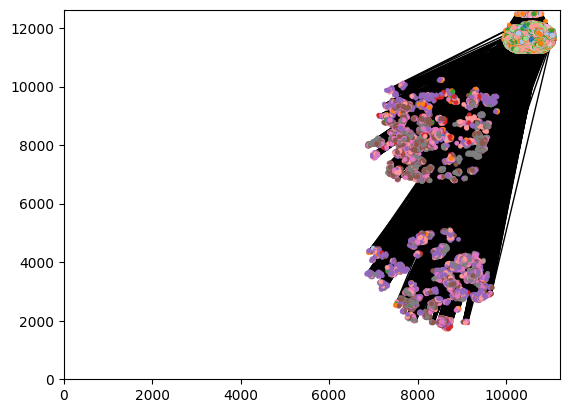

In [797]:
spacegm.plot_graph(combined_graph)

In [774]:
markers = set(adata_c.var['marker'])
indices = set(adata_x.var.index)

overlap = markers.intersection(indices)
overlap_list = list(overlap)
print(f"Overlapping values: {overlap_list}")


Overlapping values: ['CD14', 'CTLA4', 'CD163', 'TP63', 'GZMB', 'CD44', 'CD4', 'LAG3', 'CD68']


In [508]:
def add_region_id_to_graph(graph_folder, new_graph_folder, region_id):
    graph_path = os.path.join(graph_folder, f"{region_id}.gpkl")
    new_graph_path = os.path.join(new_graph_folder, f"{region_id}.gpkl")
    if os.path.exists(graph_path):
        with open(graph_path, 'rb') as f:
            graph = pickle.load(f)

        graph.region_id = region_id
        with open(new_graph_path, 'wb') as f:
            pickle.dump(graph, f)
        print(f"Updated graph for region {region_id} saved to {graph_path}.")
    else:
        print(f"Graph file for region {region_id} does not exist.")

In [510]:
combined_graph_folder = "output_combined/graph"
new_combined_graph_folder = "output_combined_mod/graph"
for region_id in region_ids[:12]:
    print(f"Processing region {region_id}...")
    add_region_id_to_graph(combined_graph_folder, new_combined_graph_folder, region_id)

print("All graphs updated with region_id.")

Processing region S16-2647 B2_margin...
Updated graph for region S16-2647 B2_margin saved to output_combined/graph/S16-2647 B2_margin.gpkl.
Processing region BA12-166 A2_tumor...
Updated graph for region BA12-166 A2_tumor saved to output_combined/graph/BA12-166 A2_tumor.gpkl.
Processing region H19-38010_tumor...
Updated graph for region H19-38010_tumor saved to output_combined/graph/H19-38010_tumor.gpkl.
Processing region S16-25171 A1_tumor...
Updated graph for region S16-25171 A1_tumor saved to output_combined/graph/S16-25171 A1_tumor.gpkl.
Processing region S15-105098 B1_tumor...
Updated graph for region S15-105098 B1_tumor saved to output_combined/graph/S15-105098 B1_tumor.gpkl.
Processing region SUH15-11470 B1_margin...
Updated graph for region SUH15-11470 B1_margin saved to output_combined/graph/SUH15-11470 B1_margin.gpkl.
Processing region 1621120 B_tumor...
Updated graph for region 1621120 B_tumor saved to output_combined/graph/1621120 B_tumor.gpkl.
Processing region S19-27363 2

In [511]:
dataset_root = "output_combined_mod"
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'graph', 
    'processed_folder_name': 'tg_graph', 
    'node_features': ["cell_type", "biomarker_expression", "center_coord"], 
    'edge_features': ["edge_type", "distance"],

    'subgraph_size': 3,  
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}

feature_kwargs = {
    "biomarker_expression_process_method": "linear",
    "biomarker_expression_lower_bound": 0,
    "biomarker_expression_upper_bound": 18,
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

Processing...
Done!


(3642.625, 4015.375, 2902.125, 3274.875)

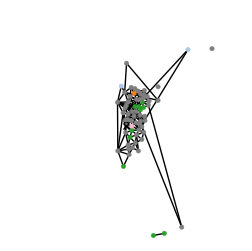

In [515]:
i = 0
j = 734

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

In [516]:
dataset.save_all_subgraphs_to_chunk()

In [ ]:
graph_label_file = 'input_codex/metadata.csv'

label_df = pd.read_csv(graph_label_file)

if 'REGION_ID' in label_df.columns:
    label_df.set_index('REGION_ID', inplace=True)
updated_file_path = "input_codex/updated_metadata.csv"
label_df.to_csv(updated_file_path)

In [538]:
graph_label_file = 'input_codex/updated_metadata.csv'

transformers = [
    spacegm.AddGraphLabel(graph_label_file, tasks=['OS_high_low']),
]

dataset.set_transforms([]) 
d1 = dataset[0]

dataset.set_transforms(transformers)
d2 = dataset[0]

In [540]:
display(d1)
display(d2)

Data(x=[171, 15], edge_index=[2, 1046], edge_attr=[1046, 2], center_node_index=59, original_center_node=10617, num_nodes=171, region_id='1621120 B_tumor', component_id=0)

Data(x=[183, 15], edge_index=[2, 1078], edge_attr=[1078, 2], center_node_index=79, original_center_node=9951, num_nodes=183, region_id='1621120 B_tumor', component_id=0, graph_y=[1, 1], graph_w=[1, 1])

In [541]:
 model_kwargs = {
    'num_layer': dataset.subgraph_size, 
    'num_node_type': len(dataset.cell_type_mapping) + 1, 
    'num_feat': dataset[0].x.shape[1] - 1, 
    'emb_dim': 512, 
    'num_node_tasks': 0,  
    'num_graph_tasks': 1, 
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cpu'

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(18, 512)
    (feat_embedding): Linear(in_features=14, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [557]:
 train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  
    'num_iterations': 100,  
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,
}

In [558]:

evaluate_kwargs = {
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 10,
    'score_file': os.path.join(model_save_root, 'GIN-example.txt'),
    'model_folder': os.path.join(model_save_root, 'GIN-example'),
}
train_kwargs.update(evaluate_kwargs)

In [559]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    train_inds=[0, 1, 2, 3, 4, 5, 6],
    valid_inds=[0, 1, 2, 3, 4, 5, 6],
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40
Finished iterations 50
Finished iterations 60
Finished iterations 70
Finished iterations 80
Finished iterations 90
Finished iterations 100


In [560]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,graph-score,0.859,Valid,graph-score,0.844

Eval-Full-Graph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Subgraph,Train,graph-score,0.969,Valid,graph-score,0.971

Eval-Full-Graph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Subgraph,Train,graph-score,0.995,Valid,graph-score,0.994

Eval-Full-Graph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Subgraph,Train,graph-score,0.999,Valid,graph-score,0.997

Eval-Full-Graph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Subgraph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Full-Graph,Train,graph-score,1.000,Valid,graph-score,1.000

Eval-Subgraph,Train,graph-score,0.745,Valid,graph-score,0.741

Eval-Full-Graph,Train,graph-score,0.583,Valid,graph-score,0.583

Eval-Subgraph,Train,graph-score,0.921,Valid,graph-score,0.935

Eval-Full-Graph,Train,graph-score,0.750,Valid,graph-score,0.750

Eval-Subgraph,Train,graph-score,0.811,Valid,graph-score,0.821

Eval-Full-Graph,Train,graph-score,0.667,V

In [562]:
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, inds=np.arange(12), print_progress=True)
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
predict on 4
predict on 5
predict on 6
predict on 7
predict on 8
predict on 9
predict on 10
predict on 11
On region 1621120 B_tumor, average prediction: 0.088
On region BA12-166 A2_tumor, average prediction: 0.142
On region H19-38010_tumor, average prediction: 0.752
On region S15-105098 B1_tumor, average prediction: 0.700
On region S16-25171 A1_tumor, average prediction: 0.369
On region S16-2647 B2_margin, average prediction: 0.175
On region S19-27363 2B_margin, average prediction: 0.624
On region S20-8605 S12_margin, average prediction: 0.232
On region S21-21003 D5_tumor, average prediction: 0.610
On region S21-6166 B5_margin, average prediction: 0.774
On region SUH15-11470 B1_margin, average prediction: 0.621
On region s18-6841 B1_margin, average prediction: 0.864
GRAPH [0.7777777777777778]


[0.7777777777777778]

In [645]:
subset_metadata = metadata[metadata['REGION_ID'].isin(regions)]
subset_metadata[['REGION_ID', 'OS_high_low']]

,REGION_ID,OS_high_low
44,S16-2647 B2_margin,0
45,BA12-166 A2_tumor,0
54,H19-38010_tumor,1
55,S16-25171 A1_tumor,0
56,S21-21003 D5_tumor,1
57,S19-27363 2B_margin,1
58,S21-6166 B5_margin,0
61,S15-105098 B1_tumor,1
62,SUH15-11470 B1_margin,0
66,S20-8605 S12_margin,1


<Axes: >

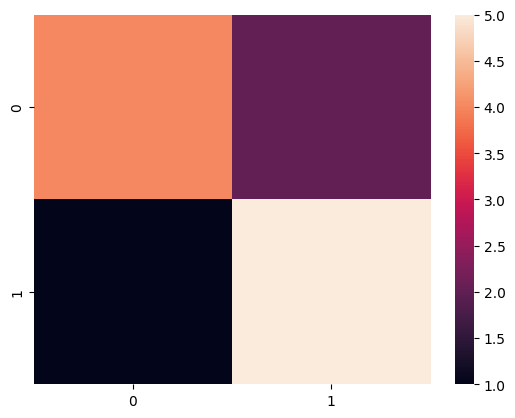

In [649]:
average_predictions = {
    "1621120 B_tumor": 0.088,
    "BA12-166 A2_tumor": 0.142,
    "H19-38010_tumor": 0.752,
    "S15-105098 B1_tumor": 0.700,
    "S16-25171 A1_tumor": 0.369,
    "S16-2647 B2_margin": 0.175,
    "S19-27363 2B_margin": 0.624,
    "S20-8605 S12_margin": 0.232, # incorrect - should be 1
    "S21-21003 D5_tumor": 0.610,
    "S21-6166 B5_margin": 0.774, # incorrect - should be 0
    "SUH15-11470 B1_margin": 0.621,  # incorrect - should be 0
    "s18-6841 B1_margin": 0.864
}

y_pred = np.array([1 if p > 0.5 else 0 for p in average_predictions.values()])

y_true = subset_metadata.loc[average_predictions.keys(), 'OS_high_low'].values

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

summary_stats = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Confusion Matrix": conf_matrix.tolist()
}

summary_stats

import seaborn as sns
sns.heatmap(conf_matrix)

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

In [827]:
accuracy, precision, recall, f1

(0.75, 0.7142857142857143, 0.8333333333333334, 0.7692307692307693)

In [651]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay

roc_auc = roc_auc_score(y_true, y_pred)

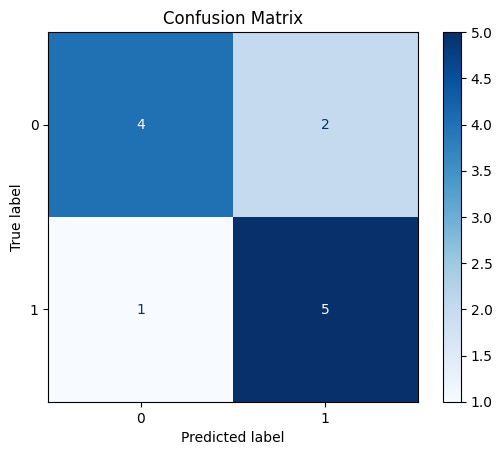

In [652]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

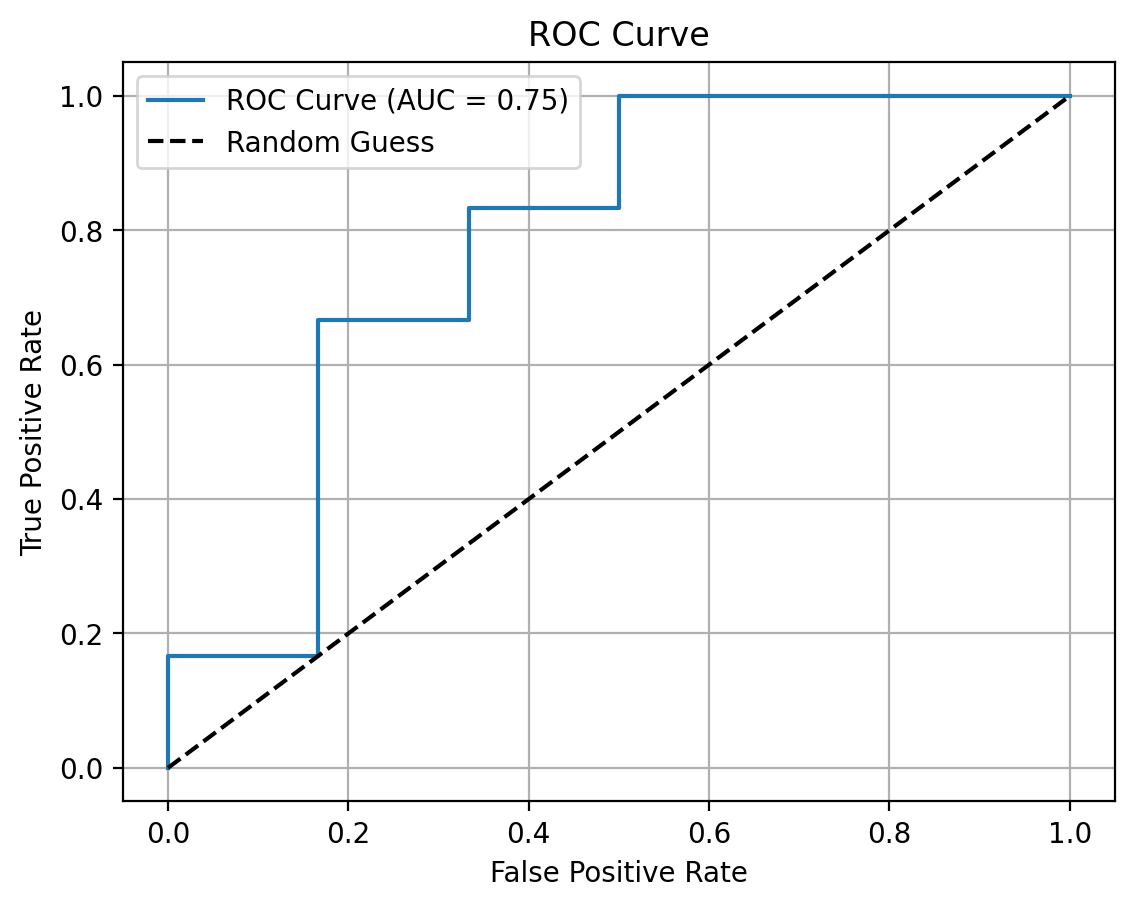

In [665]:
fpr, tpr, thresholds = roc_curve(y_true, list(average_predictions.values()))
plt.figure(dpi = 200)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [701]:
from spacegm.embeddings_analysis import (
    get_random_sampled_subgraphs,
    get_embedding,
    get_composition_vector,
    get_composition_heatmap_for_cluster,
    dimensionality_reduction_combo,
    collect_cluster_label_for_all_nodes,
)

reference_subgraph_list = get_random_sampled_subgraphs(dataset, n_samples=37773)

In [702]:
ref_node_embeddings, ref_graph_embeddings, (ref_node_preds, ref_graph_preds) = \
    get_embedding(model, reference_subgraph_list, device)
ref_composition_vectors = [
    get_composition_vector(data, n_cell_types=len(dataset.cell_type_mapping))
    for data in reference_subgraph_list
]

In [703]:
ref_pca_embs, ref_umap_emb, ref_cluster_labels, (pca, reducer, km_clustering) = \
    dimensionality_reduction_combo(
        ref_graph_embeddings, n_pca_components=20, cluster_method='kmeans', n_clusters=10)

In [704]:
heatmap, enrichment, cluster_preds, cluster_counts = \
    get_composition_heatmap_for_cluster(reference_subgraph_list, ref_cluster_labels, ref_graph_preds)

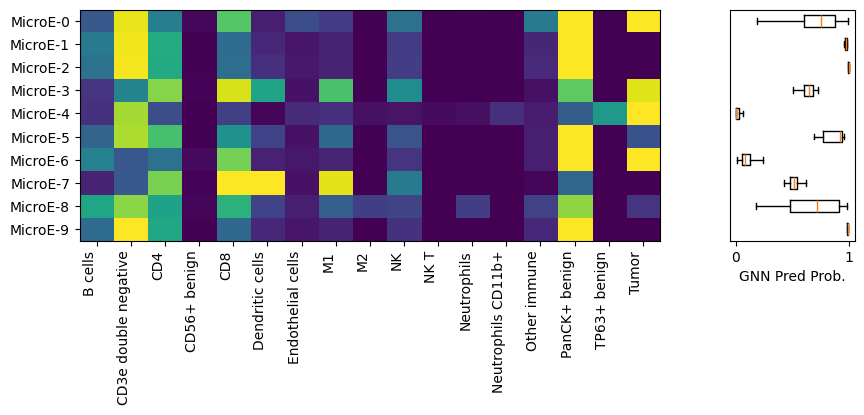

In [707]:
plot_cluster_labels = np.array(ref_cluster_labels).flatten()
plot_graph_preds = 1 / (1 + np.exp(-np.array(ref_graph_preds).flatten())) 

ctm = dataset.cell_type_mapping
n_clusters = heatmap.shape[0]

f, (a0, a1) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [14, 3]})

a0.imshow(heatmap, vmin=0, vmax=0.2, cmap='viridis', aspect='auto', extent=[0, len(ctm), 0, n_clusters])
a0.set_xticks(np.array([ctm[ct] for ct in sorted(ctm.keys())]) + 0.5,
              sorted(ctm.keys()), rotation=90, ha='right')
a0.set_yticks(np.arange(n_clusters - 1, -1, -1) + 0.5, ["MicroE-%d" % o for o in range(n_clusters)])

xs = [plot_graph_preds[np.where(plot_cluster_labels == cl)[0]] for cl in range(n_clusters)]
a1.boxplot(xs, vert=False, positions=np.arange(n_clusters), showfliers=False)
a1.set_ylim(n_clusters - 0.5, -0.5)
a1.set_xlabel("GNN Pred Prob.")
a1.set_yticks([])

plt.show() 

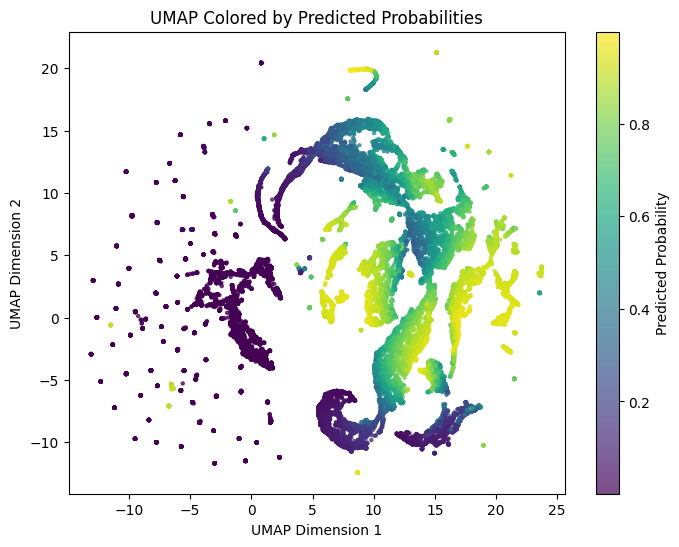

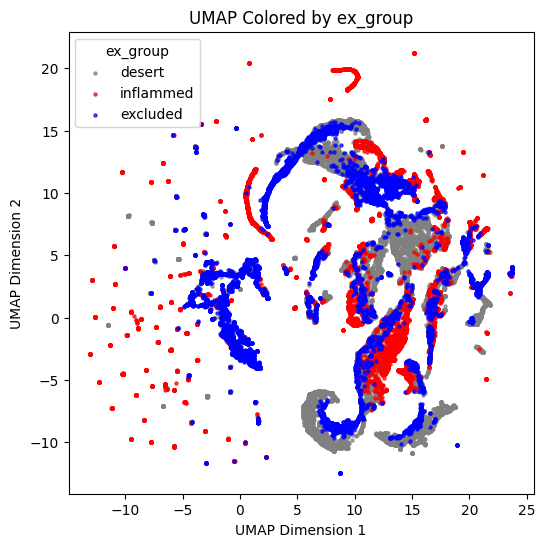

In [739]:
region_to_group = subset_metadata["ex_group"].to_dict()

region_ids = [data.region_id for data in reference_subgraph_list]
ex_groups = [region_to_group.get(region_id, "Unknown") for region_id in region_ids]

group_to_color = {"desert": "grey",
    "inflammed": "red",
    "excluded": "blue",
    
}

group_colors = [group_to_color.get(group, "black") for group in ex_groups]

plt.figure(figsize=(8, 6))
sc1 = plt.scatter(ref_umap_emb[:, 0], ref_umap_emb[:, 1], c=plot_graph_preds, cmap="viridis", s=5, alpha=0.7)
plt.colorbar(sc1, label="Predicted Probability")
plt.title("UMAP Colored by Predicted Probabilities")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(False)
plt.show()

plt.figure(figsize=(6, 6))
for group, color in group_to_color.items():
    indices = [i for i, g in enumerate(ex_groups) if g == group]
    plt.scatter(
        ref_umap_emb[indices, 0],
        ref_umap_emb[indices, 1],
        c=color,
        label=group,
        s=5,
        alpha=0.7
    )
plt.title("UMAP Colored by ex_group")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="ex_group", loc="best", frameon=True)
plt.show()


In [684]:
region_to_survival = subset_metadata['OS_high_low'].to_dict()

In [ ]:
survival_labels = [region_to_survival.get(subgraph.region_id, np.nan) for subgraph in reference_subgraph_list]

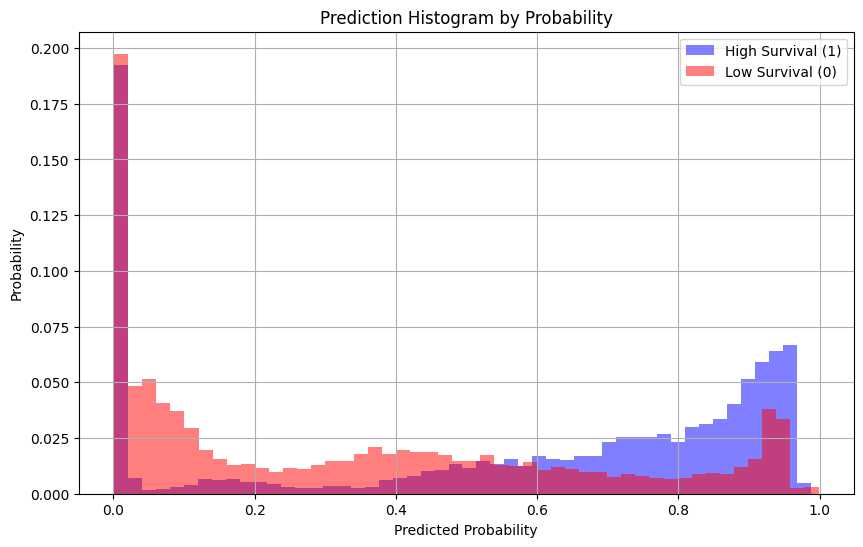

In [699]:
survival_labels = np.array(survival_labels)
high_survival_preds = plot_graph_preds[survival_labels == 1]
low_survival_preds = plot_graph_preds[survival_labels == 0]

high_counts, high_bins = np.histogram(high_survival_preds, bins=50)
low_counts, low_bins = np.histogram(low_survival_preds, bins=50)

high_probs = high_counts / high_survival_preds.size
low_probs = low_counts / low_survival_preds.size

plt.figure(figsize=(10, 6))
plt.bar(high_bins[:-1], high_probs, width=np.diff(high_bins), alpha=0.5, label="High Survival (1)", color='blue', align='edge')
plt.bar(low_bins[:-1], low_probs, width=np.diff(low_bins), alpha=0.5, label="Low Survival (0)", color='red', align='edge')
plt.xlabel("Predicted Probability")
plt.ylabel("Probability")
plt.title("Prediction Histogram by Probability")
plt.legend()
plt.grid(True)
plt.show()

Some of the code in this notebook is reused from:

https://gitlab.com/enable-medicine-public/space-gm/-/blob/main/Example.ipynb?ref_type=heads

https://gitlab.com/enable-medicine-public/space-gm/-/blob/main/Microenvironment_Clustering.ipynb?ref_type=heads

Some of the code is generated with the aid of chatGPT.